<h1>1- Definição de conceitos</h1> 

<h2>1.1- O que é a Baixa Pombalina para efeitos deste problema? </h2> 


A Baixa Pombalina, no âmbito deste problema, é a área delimitada onde iremos quantificar o número de cafés existentes.


A API TomTom permite georreferenciar uma zona através de vários métodos, incluindo:

<ul>
    <li>Definição de um raio: Se os parâmetros <code>radius</code> e <code>position</code> forem definidos, os resultados serão limitados à área especificada.</li>
    <li>Bounding box: Utilizando os parâmetros <code>topLeft</code> (canto superior esquerdo) e <code>btmRight</code> (canto inferior direito) para delimitar uma área retangular.</li>
    <li>Definição de um retângulo com <code>geobias</code>: Utiliza o parâmetro <code>geobias</code> para indicar uma preferência de localização num retângulo, influenciando a ordenação dos resultados, mas sem filtrar rigidamente.</li>
    <li>Definição de um polígono: Através da do serviço api <code>geometry search</code>, é possível marcar vários pontos para definir um polígono personalizado que limita os resultados à área geográfica especificada.</li>
</ul>

Ao pesquisar "Baixa Pombalina" na Wikipédia, encontrei a seguinte  representação geográfica representada na imagem abaixo. 

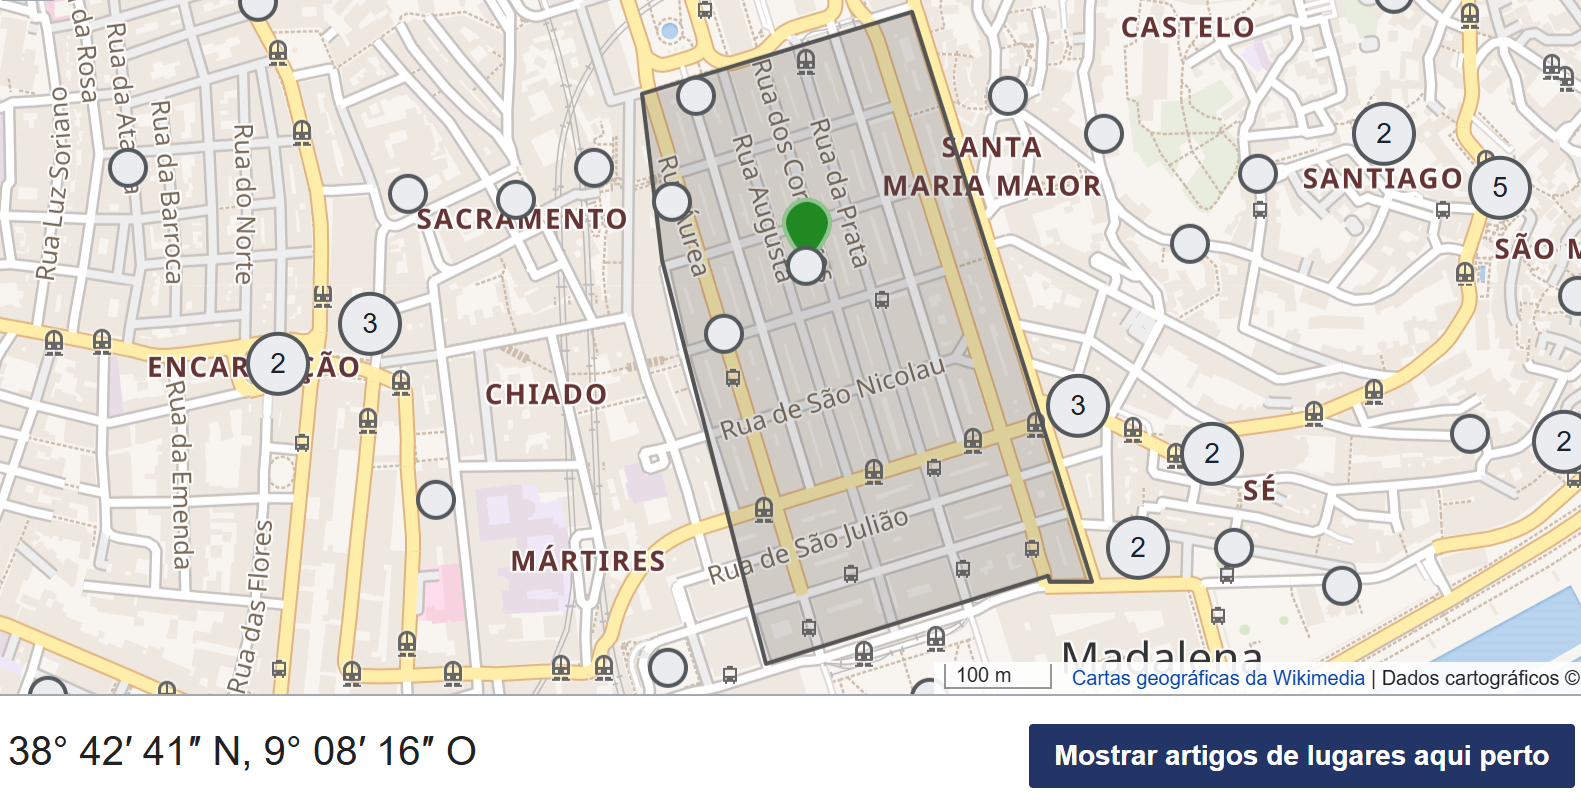


Tendo em conta que a representação acima se enquadra num polígono irregular, decidi definir a área em análise geográfica através de um polígono personalizado composto por vários vértices.

Através do site geojson.io, foram marcados vários pontos com o objetivo de definir a área do polígono representada no artigo da Wikipédia. O site permite exportar a lista de coordenadas registadas em diferentes formatos; neste caso, foi escolhido o formato CSV. O ficheiro gerado será utilizado para criar o payload do serviço GeometrySearch, no qual é passado, no seu conteúdo, um polígono com os respetivos vértices.

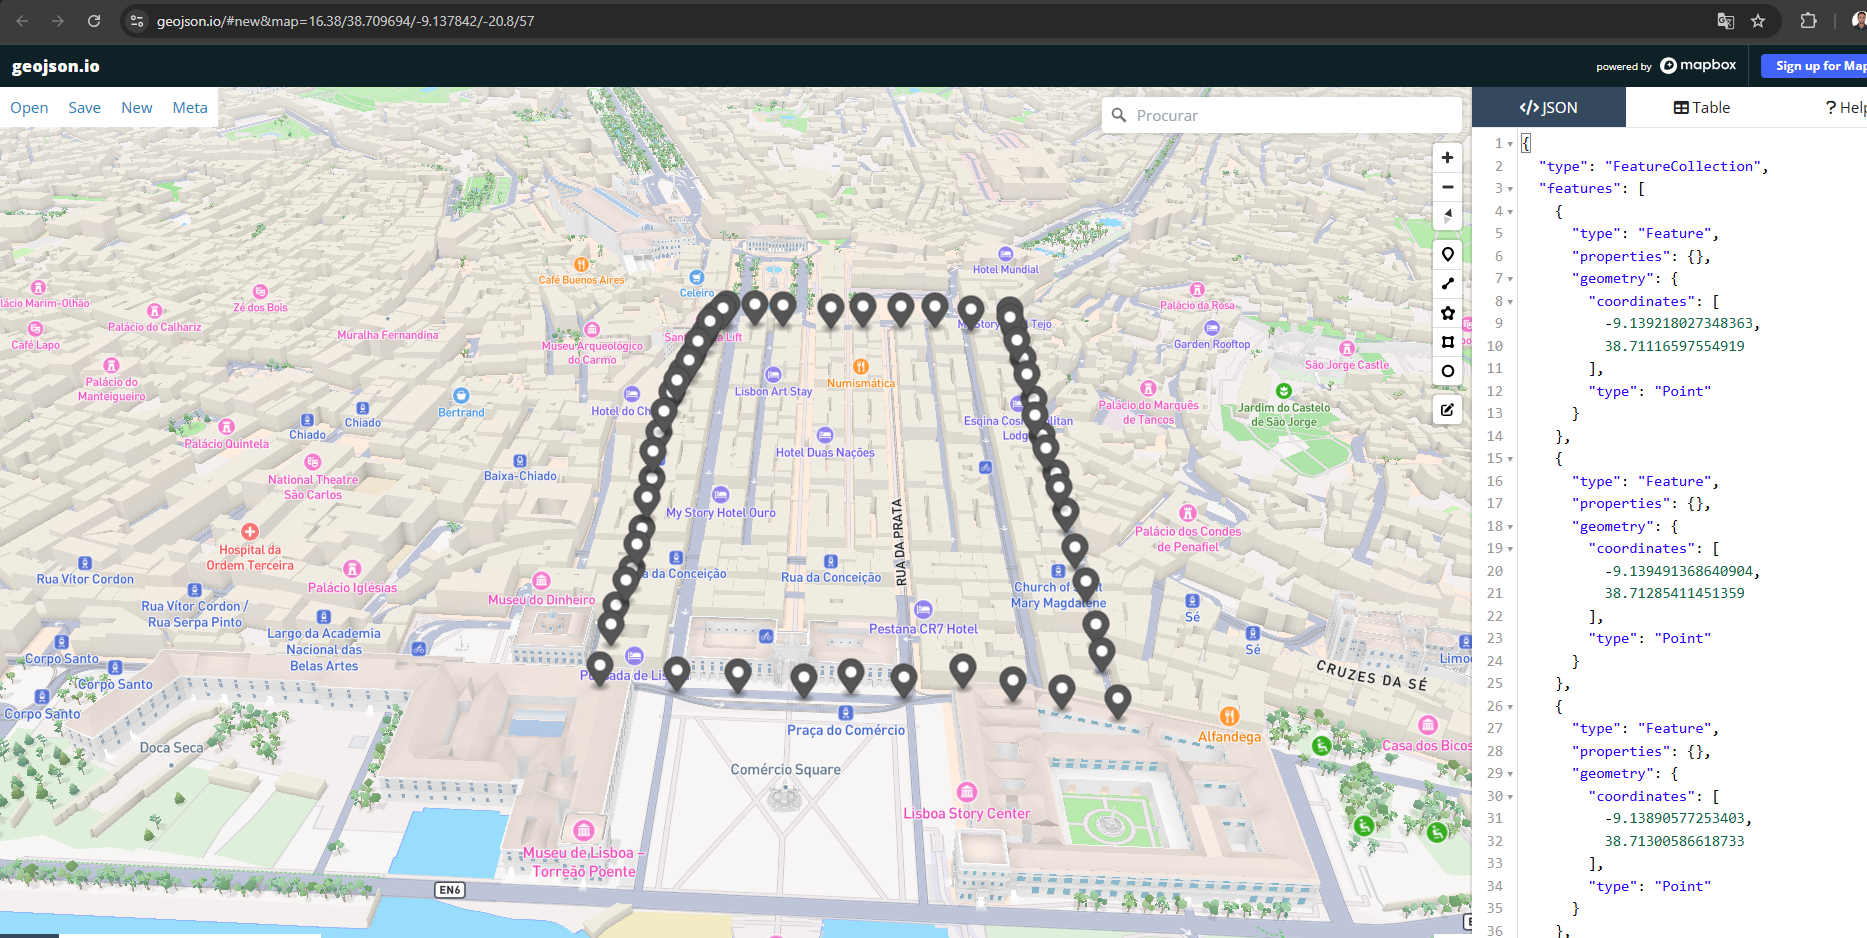


<h2>1.2- O que é uma café para efeitos deste problema?</h2> 

Para efeitos deste problema, um "café" será considerado qualquer estabelecimento comercial identificado na API TomTom como um local destinado ao consumo de café, excluindo restaurantes, que normalmente estão vocacionados para servir refeições completas. Os estabelecimentos considerados incluem:

<ul>
    <li>Cafetarias</li>
    <li>Pastelarias</li>
    <li>Espaços que ofereçam serviços de café</li>
    <li>Outros locais destinados a pequeno-almoço ou lanches</li>
</ul>


A API TomTom oferece um serviço denominado "category-search", que retorna uma lista de IDs das categorias de pontos de interesse disponíveis para pesquisa nos seus serviços. Com base neste serviço, foi definido um conjunto de palavras-chave para incluir ou excluir categorias devolvidas, caso estas contivessem essas palavras no respetivo nome ou na propriedade de sinónimos. Assim, foi criada uma lista de categorias que se enquadram como pontos de interesse do tipo "café".

<table border="1">
    <thead>
        <tr>
            <th>Palavras-Chave</th>
            <th>Palavras-Chave Exclusão</th>
        </tr>
    </thead>
    <tbody>
        <tr><td>Café</td><td>restaurant</td></tr>
        <tr><td>Coffee</td><td>wine bar</td></tr>
        <tr><td>Bakery</td></tr>
        <tr><td>Cafe</td></tr>
        <tr><td>Cafeteria</td></tr>
        <tr><td>Breakfast</td></tr>
        <tr><td>Snack</td></tr>
        <tr><td>Tea</td></tr>
        <tr><td>Pastry</td></tr>
        <tr><td>Lounge</td></tr>
        <tr><td>Doughnut</td></tr>
        <tr><td>Dessert</td></tr>
        <tr><td>Bistro</td></tr>
        <tr><td>Espresso</td></tr>
        <tr><td>Bar</td></tr>
        <tr><td>Pastel de Nata</td></tr>
        <tr><td>Portuguese custard tart</td></tr>
    </tbody>
</table>


<h1>2- Implementação</h1>

<h2>Importação de Livrarias</h2>

In [1]:
import requests
import pandas as pd
import json
import csv
import folium
from IPython.display import display
import uuid
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup
from base64 import b64decode

<h2>Constantes</h2>

In [2]:
API_KEY = input("Por favor, insere a tua API_KEY: ")
MAX_CATEGORIES = 10
LIMIT_RECORDS_API = 100
KEYWORD_FILE = "data/keywords_list.csv"
PAYLOAD_POLYGON_FILE = "logs/payload_polygon_vertices.txt"
CATEGORY_ID_FILE = "data/categories_id.csv"
COORDINATES_FILE = "data/input_coordinates.csv"
RESULT_POI_API_TOMTOM = "resulted_poi_api_tomtom.csv"
VALIDATED_POI_GOOGLE = "validated_poi_googlesearch.csv"
SAVE_LOG_APIS = True

<h2>2.1- Obter Lista de Categorias onde se incluem os pontos de Interesse</h2>

Esta função é responsável por ler a lista de palavras-chave para incluir ou excluir categorias, definida no ficheiro CSV "keywords_list.csv", e criar listas com os respetivos conteúdos.

In [3]:
# Esta função lê lista de palavras-chave a incluir/excluir na consulta de categorias da API de Categorias TomTom
def process_keywords(input_file):
    try:
        keywords = []
        exclude_keywords = []

        # Ler o ficheiro CSV
        with open(input_file, mode='r', encoding="utf-8") as file:
            reader = csv.reader(file)
            next(reader)  # Ignorar o cabeçalho
            for row in reader:
                if len(row) >= 2:  # Certificar que existem pelo menos duas colunas
                    if len(row[0]) > 1:
                        keywords.append(row[0].strip())
                    if len(row[1]) > 1:
                        exclude_keywords.append(row[1].strip())

        return keywords, exclude_keywords
    except FileNotFoundError:
        print(f"Erro: O ficheiro '{input_file}' não foi encontrado.")
    except Exception as e:
        print(f"Ocorreu um erro ao processar o ficheiro: {e}")


input_file = KEYWORD_FILE
keywords, exclude_keywords = process_keywords(input_file)

print(keywords)
print(exclude_keywords)


['Café', 'Coffee', 'Bakery', 'Cafe', 'Cafeteria', 'Breakfast', 'Snack', 'Tea', 'Pastry', 'Lounge', 'Doughnut', 'Dessert', 'Bistro', 'Espresso', 'Bar', 'Brunch', 'Pastel de Nata', 'Portuguese custard tart']
['restaurant', 'barracks', 'nails', 'plateau', 'wine bar', 'Cabaret', 'guesthouse', 'hotel', 'hostel']



O código abaixo implementa chamada à  API **TomTom poiCategories**, que permite extrair informações das categorias possíveis de pontos de interesse. O conteúdo devolvido pela API é verificado para garantir que cumpre as regras das palavras-chave definidas no ponto anterior. O conteúdo validado é, então, guardado num ficheiro CSV.


- **Parâmetros**:
  - `url`: url da API.
  - `params`: Dicionário com parametros necessários à invocação da API, nesse caso a chave de acesso.
  - `keywords`: Conjunto de palavras chaves a ter em consideração a seleção da categoria
  - `exclude_keywords`: Conjunto de palavras chaves a ter em consideração a não seleção da categoria

- **Fluxo**:
  1. Define os parâmetros da requisição HTTP.
  2. Envia a requisição `GET` para a API.
  3. Retorna a resposta em formato JSON, se a chamada for bem-sucedida.
  4. Em caso de erro, imprime o código de status e a mensagem de erro.

---

In [4]:
# Endereço Api Categorias Possiveis de Pontos de Interesse
url = "https://api.tomtom.com/search/2/poiCategories.json"
params = {
    "key": API_KEY  
}


def fetch_and_process_category_api(url, params, keywords, exclude_keywords):
    try:
        # Chamada à API
        response = requests.get(url, params=params)

        # Verificar se request bem-sucedido
        if response.status_code == 200:
            data = response.json()  # Obter a resposta em formato JSON

            # Extrair categorias
            categories = data.get("poiCategories", [])

            # Extrair conteúdo: ids, nomes e sinônimos
            extracted_data = []
            for category in categories:

                # Combinar nome e sinônimos numa única string para pesquisa
                name_synonim_text = category.get("name", "").lower() + " " + " ".join(category.get("synonyms", [])).lower()
                if any(keyword.lower() in name_synonim_text for keyword in keywords) and not any(exclude_keyword.lower() in name_synonim_text for exclude_keyword in exclude_keywords):
                    accepted_category = {
                        "id": category.get("id"),
                        "name": category.get("name"),
                        "synonyms": category.get("synonyms", [])
                    }
                    extracted_data.append(accepted_category)

            # Criar o dataframe
            df = pd.DataFrame(extracted_data)

            if not df.empty:
                print(df)

                # Guardar informação de categorias num ficheiro CSV
                df.to_csv("data/categories_id.csv",sep=";", index=False)

                ids_Categorias = ";".join(map(str, df['id'].unique()))
                return ids_Categorias
            else:
                print("Nenhum dado foi extraído das categorias.")
                return None
        else:
            print(f"Erro na chamada da API: {response.status_code}")
            return None
    except requests.RequestException as re:
        print(f"Erro na requisição: {re}")
    except KeyError as ke:
        print(f"Erro ao acessar dados da resposta: {ke}")
    except ValueError as ve:
        print(f"Erro ao converter dados JSON: {ve}")
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")

# Chamada à função
ids_Categorias = fetch_and_process_category_api(url, params, keywords, exclude_keywords)
print(ids_Categorias)
 

         id              name  \
0      9376          Café/Pub   
1   9379004               Bar   
2   7315007            Bistro   
3   9376002              Café   
4   7315147         Cafeteria   
5   9379006      Cocktail Bar   
6   9376006       Coffee Shop   
7   9379009       Comedy Club   
8   9361018            Bakery   
9   9376004     Internet Café   
10  9379008         Jazz Club   
11  9379010      Karaoke Club   
12  7315039          Pub Food   
13  7315143         Salad Bar   
14  9376005         Tea House   
15  7315149  Yogurt/Juice Bar   
16     7358        Truck Stop   
17     7375         Toll Gate   

                                             synonyms  
0                                                  []  
1                                                  []  
2                                                  []  
3                                              [Cafe]  
4                                         [Cafetaria]  
5                               [Coc

<h2>2.2- Extração de informação dos pontos de interesse, incluídos na lista de categorias definidas no passo anterior, respeitando área geográfica delimitada através da Api GeometrySearch</h2>

<h3>2.2.1- Construção do Payload necessário no consumo da Api GeometrySearch </h3>

Esta função é responsável por extrair os pontos de latitude e longitude incluídos no ficheiro CSV gerado pelo site geojson.io e incorporar essa informação no formato de payload, onde são definidos os vértices do polígono necessário para a solicitação de pontos de interesse na área de interesse através da API GeometrySearch

In [6]:
def csv_coordinates_to_polygon(input_file_path, output_file_path):
    # Ler as coordenadas do ficheiro CSV
    coordinates = []
    with open(input_file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Ignorar o cabeçalho (lon,lat)
        for row in reader:
            lon, lat = map(float, row)  # Convertendo para floats
            coordinates.append([lat, lon])

    # Garantir que o polígono é fechado
    if coordinates[0] != coordinates[-1]:
        coordinates.append(coordinates[0])


    # Criar o payload no formato esperado
    polygon_data = {
        "geometryList": [
            {
                "type": "POLYGON",
                "vertices": [
                    f"{lat},{lon}" for lat, lon in coordinates
                ]
            }
        ]
    }

    # Guardar o JSON resultante no ficheiro de saída
    with open(output_file_path, 'w') as output_file:
        json.dump(polygon_data, output_file, indent=2)

    print(f"Ficheiro criado: {output_file_path}")
    return polygon_data


# Chamada à função
payload_geometry_search= csv_coordinates_to_polygon(COORDINATES_FILE,PAYLOAD_POLYGON_FILE)
print(payload_geometry_search)

Ficheiro criado: logs/payload_polygon_vertices.txt
{'geometryList': [{'type': 'POLYGON', 'vertices': ['38.712876785402386,-9.139450673684593', '38.71322090469465,-9.138238992874847', '38.71350469902515,-9.13710643598273', '38.71360250457482,-9.136562297470107', '38.712884758241074,-9.13624884305753', '38.712225251325265,-9.136030236977717', '38.71154050683134,-9.135742198935134', '38.71103472083931,-9.135555184944081', '38.71050904287165,-9.135302255209439', '38.70984454842315,-9.135067879679013', '38.70921858790771,-9.134793551466885', '38.70869664192827,-9.134575963524668', '38.70868443061414,-9.135341758873125', '38.70842773036304,-9.136336120169346', '38.70824433188412,-9.137072436651152', '38.70803175311161,-9.138032455000229', '38.70882165424294,-9.138330914451132', '38.70959639657519,-9.138609347148247', '38.71033457321727,-9.138938325596769', '38.711183202506675,-9.139214553660594', '38.71171133968042,-9.139301483764541', '38.71235459899907,-9.13946467816092', '38.7128767854023

<h3>2.2.2- Obter  pontos de Interesse através da Api GeometrySearch</h3>

A API Geometry Search permite passar como parâmetro uma lista dos IDs das categorias de pontos de interesse para as quais pretendemos obter informação. Tendo em conta que a API tem uma limitação de apenas permitir o envio de, no máximo, 10 categorias por pedido, foi definido este valor máximo a ser respeitado em cada pedido. Caso a lista de categorias exceda o valor máximo permitido, o processo deverá subdividr o pedido à API em vários pedidos, respeitando o limite máximo de categorias por pedido. 

A função split_categories divide a lista de categorias em novas listas respeitando o limite máximo de categorias por pedido.

In [7]:
def split_categories(category_set, max_categories):
    categories = category_set.split(";")
    return [categories[i:i + max_categories] for i in range(0, len(categories), max_categories)]

category_batches = split_categories(ids_Categorias, MAX_CATEGORIES)
print(category_batches)

[['9376', '9379004', '7315007', '9376002', '7315147', '9379006', '9376006', '9379009', '9361018', '9376004'], ['9379008', '9379010', '7315039', '7315143', '9376005', '7315149', '7358', '7375']]


O código abaixo implementa chamada à  API **TomTom Geometry Search**, que permite pesquisar pontos de interesse (POIs) dentro de uma área geográfica definida. 


- **Parâmetros**:
  - `api_key`: Chave de autenticação para a API.
  - `category_set`: Conjunto de categorias de pontos de interesse (POIs) a serem pesquisadas.
  - `geometry_list`: Lista de coordenadas dos vertices do poligono que define a area geográfica da análise
  - `offset`: Posição inicial para paginação dos resultados (valor padrão: 0).
- **Fluxo**:
  1. Define os parâmetros e o corpo da requisição HTTP.
  2. Envia a requisição `POST` para a API.
  3. Retorna a resposta em formato JSON, se a chamada for bem-sucedida.
  4. Em caso de erro, imprime o código de status e a mensagem de erro.

---



In [8]:
def call_geometry_search(api_key, category_set, geometry_list, offset=0):
    try:
        # URL da API
        url = "https://api.tomtom.com/search/2/geometrySearch/.json"

        # Parâmetros da API
        params = {
            "key": api_key,
            "categorySet": category_set,
            "limit": LIMIT_RECORDS_API,
            "offset": offset
        }

        # Body Payload
        body = geometry_list

        # Realizar a chamada à API
        response = requests.post(url, params=params, json=body)

        # Verificar o status da resposta
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Erro na chamada à API. Status code: {response.status_code}")
            print("Mensagem de erro:", response.text)
            return None

    except requests.RequestException as e:
        print(f"Erro ao realizar a requisição: {e}")
        return None


A função abaixo faz extração dos dados da resposta da API para um `DataFrame` da livraria pandas.

- **Parâmetros**:
  - `response`: Resposta JSON da API.
- **Fluxo**:
  1. Itera sobre os resultados retornados pela API.
  2. Extrai informações importantes, como nome, telefone, endereço e posição (latitude e longitude).
  3. Organiza os dados numa estrutura de lista de dicionários.
  4. Retorna um `DataFrame` contendo os dados organizados.

---

In [9]:
def parse_response_to_dataframe(response):
    data = []
    for result in response.get('results', []):
        poi = result.get('poi', {}) 
        address = result.get('address', {})
        poi_name = poi.get('name', '')
        poi_categoryset = [str(category.get('id')) for category in poi.get('categorySet', [])]
        poi_phone = poi.get('phone', '') 
        poi_categories = poi.get('categories', [])  
        poi_street_name = address.get('streetName', '') 
        poi_municipality_subdivision = address.get('municipalitySubdivision', '') 
        poi_postal_code = address.get('postalCode', '') 
        poi_freeform_address = address.get('freeformAddress', '')
        position = result.get('position', {})
        poi_position_lat = position.get('lat', '')
        poi_position_lon = position.get('lon', '')

        data.append({ 
            'name': poi_name, 
            'phone': poi_phone, 
            'address.streetName': poi_street_name, 
            'address.municipalitySubdivision': poi_municipality_subdivision, 
            'address.postalCode': poi_postal_code, 
            'freeformAddress': poi_freeform_address,
            'position_lat': poi_position_lat,
            'position_lon': poi_position_lon, 
            'categoryset': ", ".join(poi_categoryset),
            'categories': ", ".join(poi_categories)
        }) 
    return pd.DataFrame(data)

A função abaixo gere a paginação da API para garantir que todos os resultados são recolhidos. Apesar de ter sido a logica de implementação da paginação através do parametro offset, a api não responde corretamente a este parametro.

- **Parâmetros**:
  - `api_key`: Chave de autenticação para a API.
  - `category_set`: Conjunto de categorias de POIs.
  - `geometry_list`: Lista de geometrias que define as áreas de interesse.
- **Fluxo**:
  1. Inicializa o `offset` e uma lista para armazenar os `DataFrames`.
  2. Realiza chamadas iterativas à API utilizando a função `call_geometry_search`.
  3. Determina o número total de resultados e o número de registos retornados por chamada.
  4. Adiciona os dados retornados a um `DataFrame` e incrementa o `offset` para buscar a próxima página.
  5. Combina todos os `DataFrames` num único `DataFrame` consolidado.

---

In [10]:
def fetch_all_results(api_key, category_set, geometry_list):
    offset = 0
    dataframes = []
    total_results = float('inf')  # Inicialmente desconhecido

    while offset < total_results:
        # Chamar a API com o offset atual
        response = call_geometry_search(api_key, category_set, geometry_list, offset)

        if response:
            # Obter total de resultados e registos retornados
            total_results = response.get('summary', {}).get('totalResults', 0)
            num_results = response.get('summary', {}).get('numResults', 0)

            # Converter resposta para DataFrame
            df = parse_response_to_dataframe(response)
            dataframes.append(df)

            # Incrementar o offset
            offset += num_results

            # Guardar a resposta logst resposta comunicações api 
            if SAVE_LOG_APIS:
                unique_filename = f"response_geometry_search_{uuid.uuid4()}.txt"
                with open("logs/"+unique_filename, "w", encoding="utf-8") as file:
                    json.dump(response, file, ensure_ascii=False, indent=4)

        else:
            print("Erro na resposta da API ou resposta inválida.")
            break

    # Combinar todos os DataFrames num só
    final_df = pd.concat(dataframes, ignore_index=True)
    return final_df

O código abaixo é responsável por implementar o fluxo de execução das funções definidas anteriormente.

1. **Iteração por Batch de Categorias**:
   - O código divide as categorias em batches (conjuntos) para respeitar o limite da API de 10 categorias por chamada.
   - Para cada batch, chama a função `fetch_all_results` para obter todos os resultados.

2. **Ordenação e guardar resultados**:
   - O `DataFrame` consolidado é ordenado alfabeticamente pela coluna `name`.
   - O `DataFrame` final é salvo num ficheiro CSV chamado `resulted_poi_api_tomtom.csv`.

---

In [12]:
# Exemplo de utilização
dataframes = []
for batch in category_batches:
    batch_category_set = ",".join(batch)
    result_df = fetch_all_results(API_KEY, batch_category_set, payload_geometry_search)
    dataframes.append(result_df)

apidata_df = pd.concat(dataframes, ignore_index=True)

# Guardar log em CSV
apidata_df = apidata_df.sort_values(by='name', ascending=True)

# Reiniciar os índices após a ordenação
apidata_df.reset_index(drop=True, inplace=True)
apidata_df.to_csv(RESULT_POI_API_TOMTOM,sep=";", index=False)


<h3>2.2.3- Validar Informação recebida da APi TomTom</h3>

O código abaixo realiza duas operações principais no DataFrame `apidata_df`: 

1. **Visualização de valores ausentes nos registos recebidos**:
   - Foi possivel verificar, que o campo  numero de telefonece tem registos em branco, assim desta forma não será um elemento a ter em conta para pesquisa em outras fontes.
2. **Verificação de valores duplicados pela morada completa normalizada**:
   - Foi possivel verificar, dois pontos de interesse duplicados: Benedita Bakery & Breakfas, Pastelaria Ferrari.

                               name             phone address.streetName  \
4       Benedita Bakery & Breakfast  +351 929 442 959   Rua da Conceição   
5   Benedita Bakery &Amp; Breakfast  +351 929 442 959   Rua da Conceição   
18                          Ferrary  +351 965 579 868        Rua Augusta   
33               Pastelaria Ferrari  +351 965 579 868        Rua Augusta   

   address.municipalitySubdivision address.postalCode  \
4                Santa Maria Maior               1100   
5                Santa Maria Maior               1100   
18               Santa Maria Maior               1100   
33               Santa Maria Maior               1100   

                  freeformAddress  position_lat  position_lon categoryset  \
4   Rua da Conceição, 1100 Lisboa     38.709954     -9.136206     9361018   
5   Rua da Conceição, 1100 Lisboa     38.709948     -9.136229     9376002   
18   Rua Augusta 189, 1100 Lisboa     38.711449     -9.138187     9361018   
33   Rua Augusta 189, 110

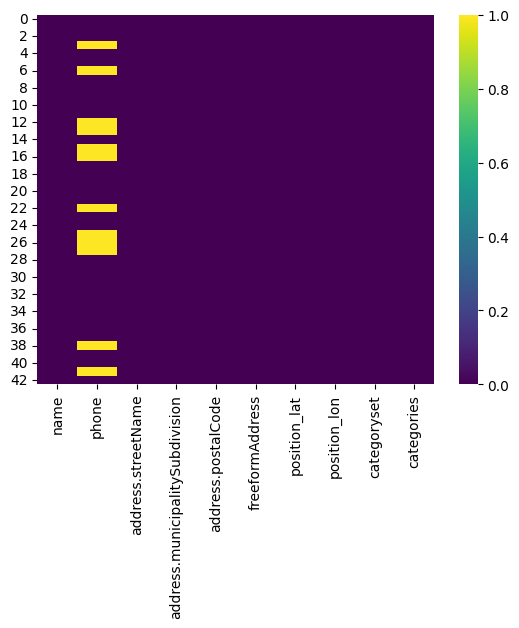

In [13]:
# Substituir strings vazias por valores nulos
apidata_df = apidata_df.replace("", np.nan)

# Apresentar variaveis com ausência de valores visualmente
sns.heatmap(apidata_df.isna(), cmap='viridis')

# Verificar registos duplicados pela morada completa normalizada
apidata_duplicated = apidata_df[apidata_df.duplicated(subset=['freeformAddress'], keep=False)]
print(apidata_duplicated)
finaldata_df = apidata_df.drop_duplicates(subset=['freeformAddress'], keep='first')
finaldata_df.to_csv(RESULT_POI_API_TOMTOM,sep=";", index=False)



<h3>2.2.4- Validar Informação recebida da APi TomTom com outra fonte.</h3>

De forma a validar se o conteudo da Api Tomtom é válido, tentei validar o conteudo do mesmo  com outra font. Inicialmente, tentei realizar web scraping utilizando o motor de busca do Google. Apesar de implementar várias medidas, como a simulação do User-Agent no cabeçalho HTTP, pausas aleatórias entre os pedidos e até uma simulação de sessão/utilização de cookies, a Google bloqueou repetidamente os meus pedidos, recebendo um status header 429.

Assim sendo tentei alternativas e encontrei a Serviço de Api Zyte que é uma solução de web scraping avançada e que facilita a extração de dados de páginas web, eliminando muitos dos desafios técnicos e bloqueios frequentemente encontrados ao realizar scraping como o descrito acima.  Este serviço oferece proxies rotativos, alternando IPs automaticamente para evitar bloqueios, lida automaticamente com CAPTCHAs e sistemas anti-bot encontrados em muitos sites.

<p>Como Funciona a Zyte?</p>
Este plataforma disponibiliza o serviço de WebScrapping através de uma  API, que permite receber os parametros necessarios a efetuar o web scrapping, lida com inumeros problemas e bloqueios a fazer web scrapping e devolve o HTML completo (ou dados estruturados) em resposta à requisição da API.


Neste projecto foi utilizado o serviço para  realizar pedidos ao motor de busca da Google, utilizando como parâmetros o nome e as moradas dos pontos de interesse obtidos no passo anterior através da API TomTom. Em seguida, o conteúdo HTML retornado é analisado para verificar a presença das palavras-chave definidas. Caso estas palavras-chave sejam encontradas no seu conteudo, a coluna "isvalid" do DataFrame será atualizada com o valor verdadeiro.

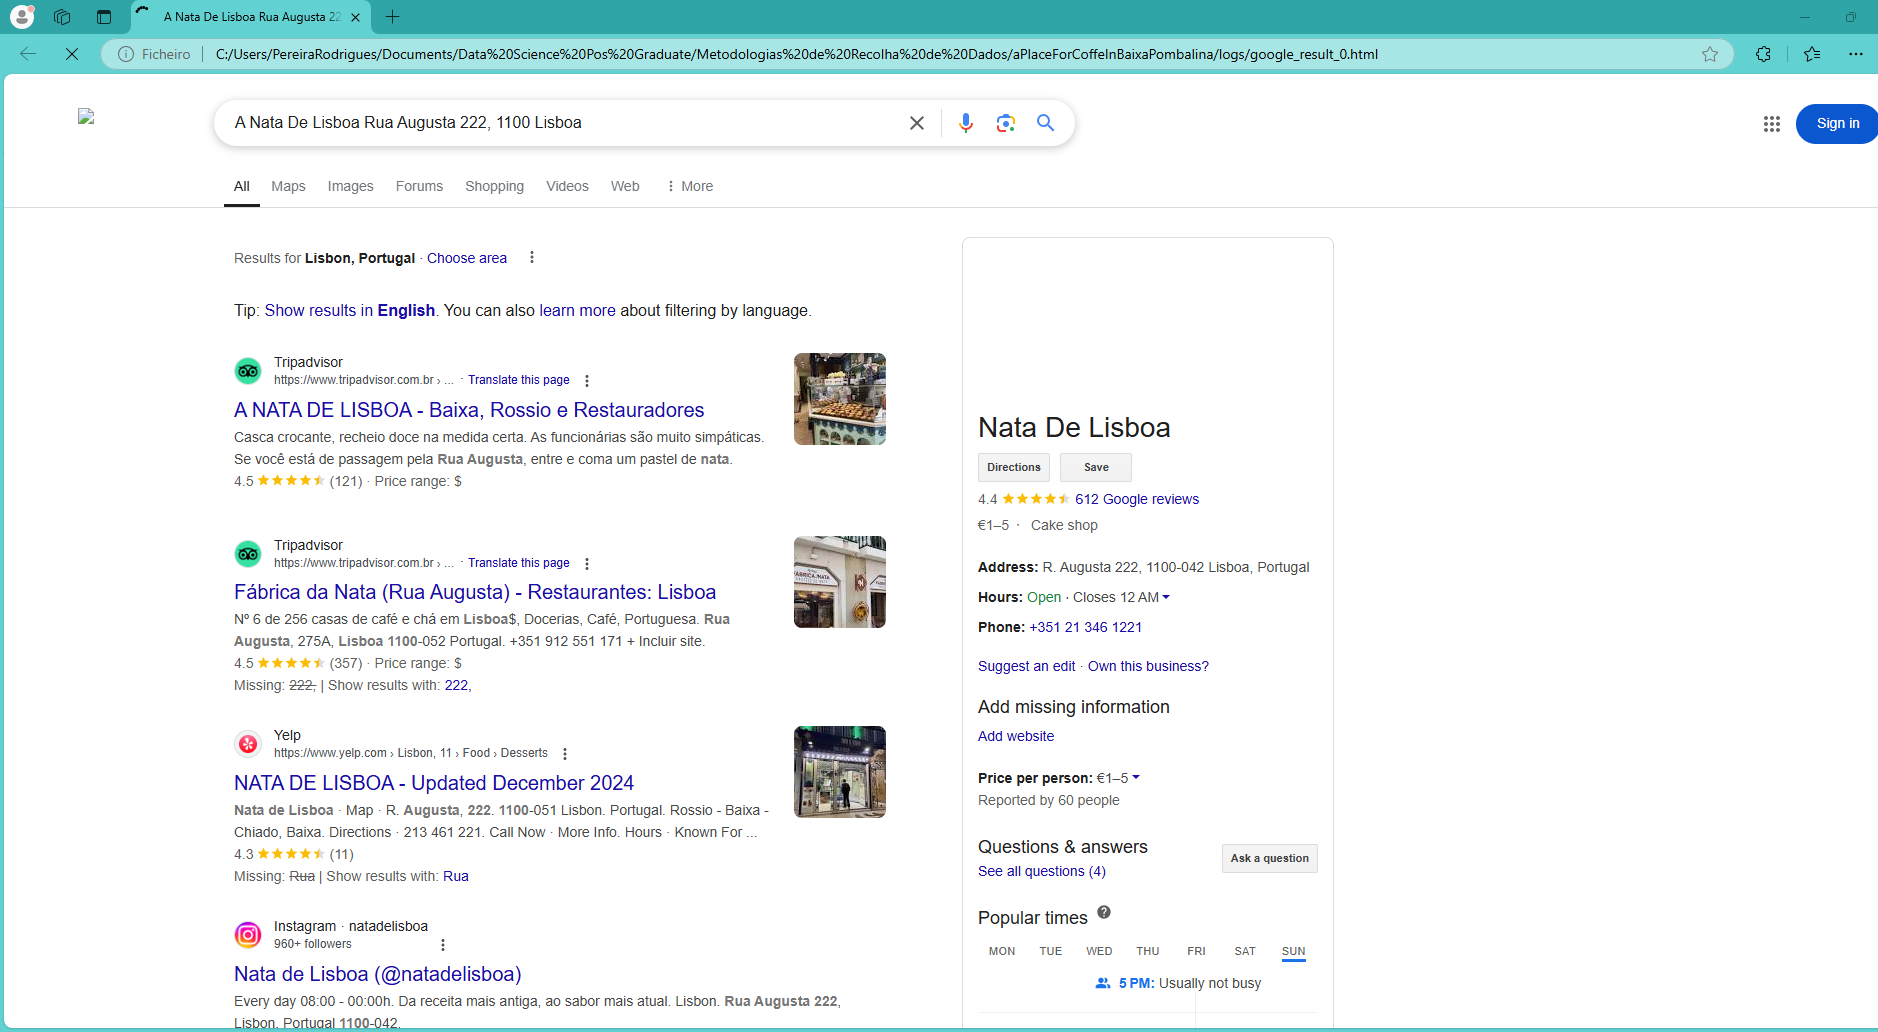






In [17]:
# Preencher com a chave da tua API
ZYTE_API_KEY = input("Por favor, insere a tua API_KEY: ")

In [ ]:
# Função para buscar HTML usando Zyte API
def fetch_page_with_zyte(url):
    try:
        response = requests.post(
            "https://api.zyte.com/v1/extract",
            auth=(ZYTE_API_KEY, ""),
            json={"url": url, "httpResponseBody": True},
            timeout=60,
        )
        if response.status_code == 200:
            # Decodificar HTML em Base64
            html_content = b64decode(response.json()["httpResponseBody"])
            return html_content.decode("utf-8")
        else:
            print(f"Erro {response.status_code} ao acessar: {url}")
            return None
    except Exception as e:
        print(f"Erro ao buscar a URL com Zyte: {e}")
        return None

# Função para validar palavras-chave no HTML
def contains_keywords(html_content, poi_name, keywords):
    if html_content:
        soup = BeautifulSoup(html_content, "html.parser")
        page_text = soup.get_text().lower()

        # Procurar o nome do POI e palavras-chave no conteúdo
        if poi_name.lower() in page_text:
            for keyword in keywords:
                if keyword.lower() in page_text:
                    return True
    return False


# Iterar os pontos de interesse obtidos na API TomTom, e pesquisar os mesmos no motor de busca Google
results = []
finaldata_df = finaldata_df.copy()
google_base_url = "https://www.google.com/search?q="
for index, row in finaldata_df.iterrows():
    print(f"Validando: {row['name']} - {row['freeformAddress']}")
    query = f"{row['name']} {row['freeformAddress']}".replace(" ", "+")
    search_url = f"{google_base_url}{query}"
    print(f"URL: {search_url}")

    # Buscar a página com a Zyte API
    html_content = fetch_page_with_zyte(search_url)
    if html_content:
        with open(f"logs/google_result_{index}.html", "w", encoding="utf-8") as f:
            f.write(html_content)  # Salvar HTML localmente para logs

    # Verificar palavras-chave no HTML
    is_valid = contains_keywords(html_content, row['name'], keywords)
    results.append(is_valid)
    
# Adicionar resultados ao DataFrame
finaldata_df.loc[:, "is_valid"] = results

# Salvar os resultados em CSV
finaldata_df.to_csv(VALIDATED_POI_GOOGLE, sep=";", index=False)
print("Validação concluída! Resultados salvos em 'google_validated_pois.csv'.")


Validando: A Nata De Lisboa - Rua Augusta 222, 1100 Lisboa
URL: https://www.google.com/search?q=A+Nata+De+Lisboa+Rua+Augusta+222,+1100+Lisboa
Validando: A Padaria Portuguesa - Rua da Prata 134, 1100 Lisboa
URL: https://www.google.com/search?q=A+Padaria+Portuguesa+Rua+da+Prata+134,+1100+Lisboa
Validando: Alice Gelato Da Meraviglie - Rua da Madalena 69, 1100 Lisboa
URL: https://www.google.com/search?q=Alice+Gelato+Da+Meraviglie+Rua+da+Madalena+69,+1100+Lisboa
Validando: Amo Brewery - Rua Augusta 53, 1150 Lisboa
URL: https://www.google.com/search?q=Amo+Brewery+Rua+Augusta+53,+1150+Lisboa
Validando: Benedita Bakery & Breakfast - Rua da Conceição, 1100 Lisboa
URL: https://www.google.com/search?q=Benedita+Bakery+&+Breakfast+Rua+da+Conceição,+1100+Lisboa
Validando: Bizzarro - Rua de São Julião, 1149 Lisboa
URL: https://www.google.com/search?q=Bizzarro+Rua+de+São+Julião,+1149+Lisboa
Validando: Bonbon Cha - R. Da Assunção 82, 1100 Lisboa
URL: https://www.google.com/search?q=Bonbon+Cha+R.+Da+Ass

O serviço Zeppy, permite criar uma conta trial com crédito de 5 dolares. Para o efeito deste trabalho, foram feitos mais de 500 pedidos, a plataforma oferece total controlo sobre custos, e é possivel verificar com detalhe o custo da resultado dos pedidos ao serviço, em que nesse caso foram cerca de 17 cêntimos.

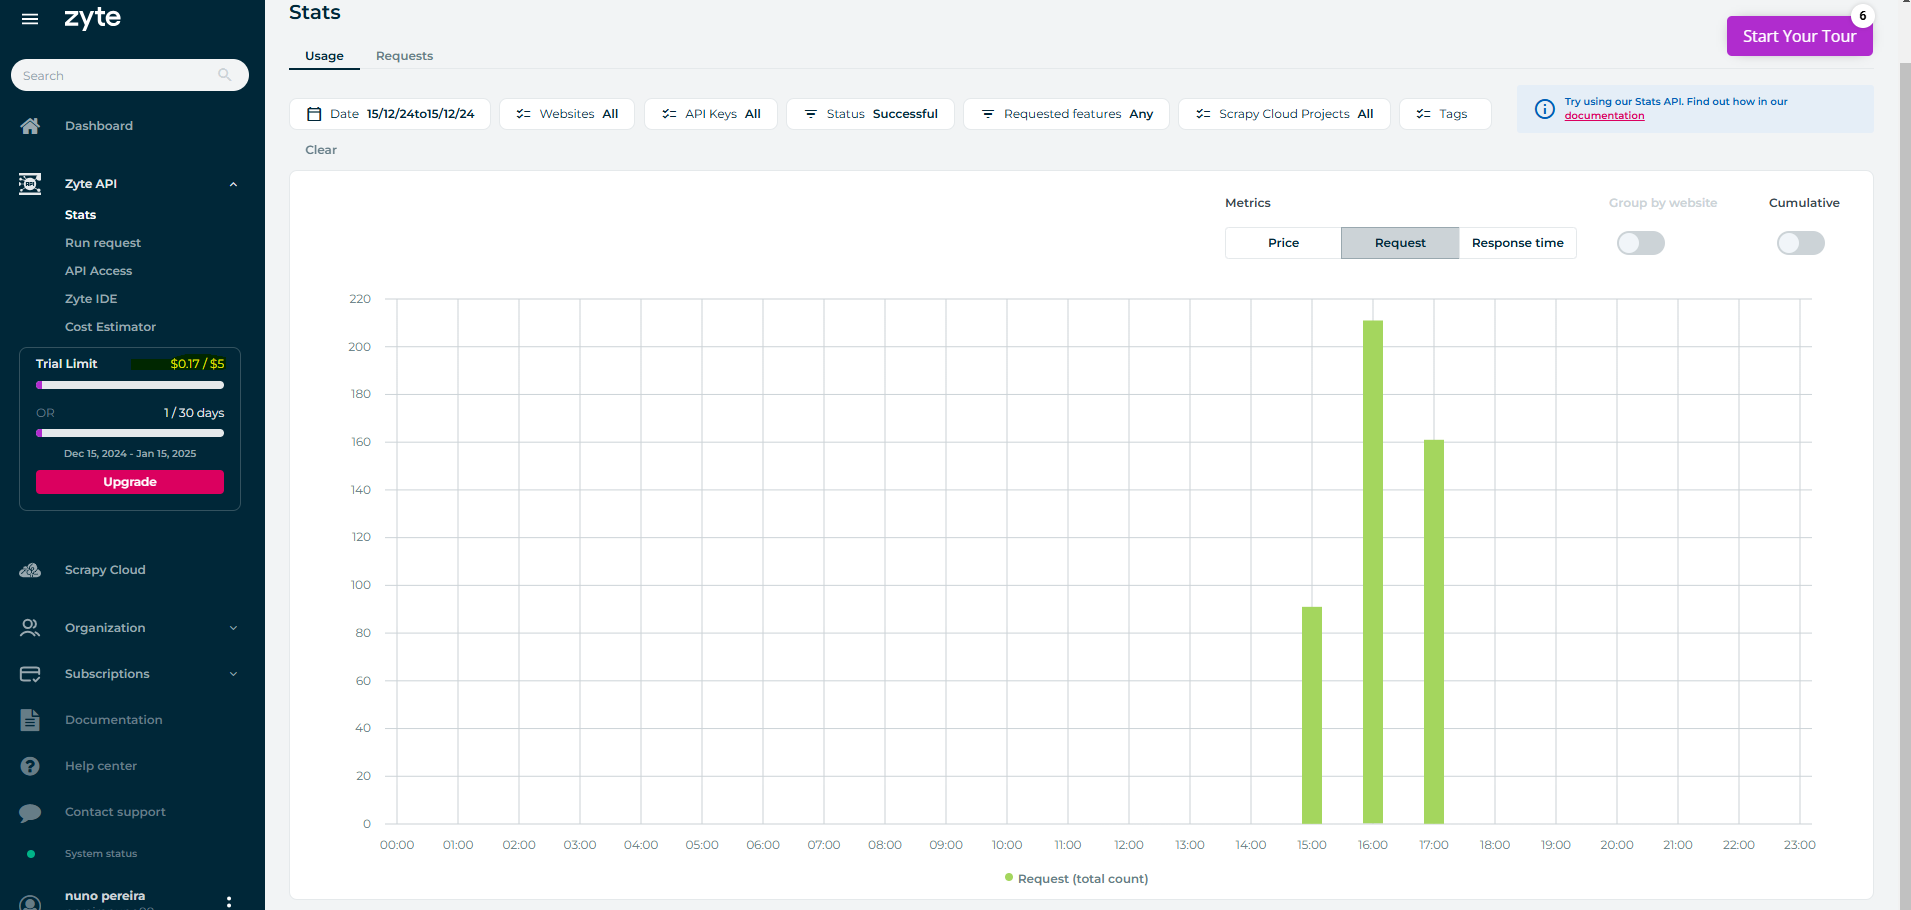

Apesar de na pasta logs, estár guardado o resultado de cada resposta html do WebScrapper, a plataforma permite consultar o log detalhado dos pedidos


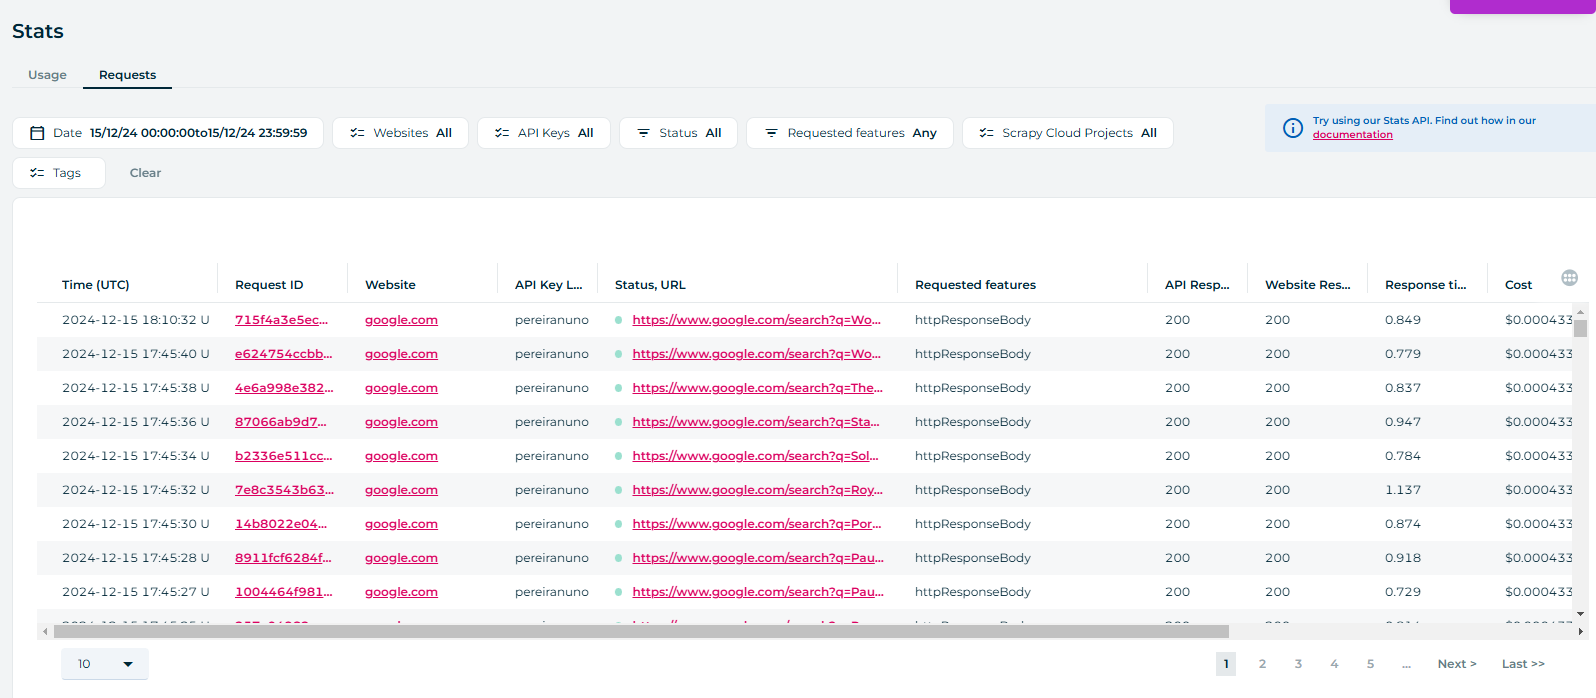
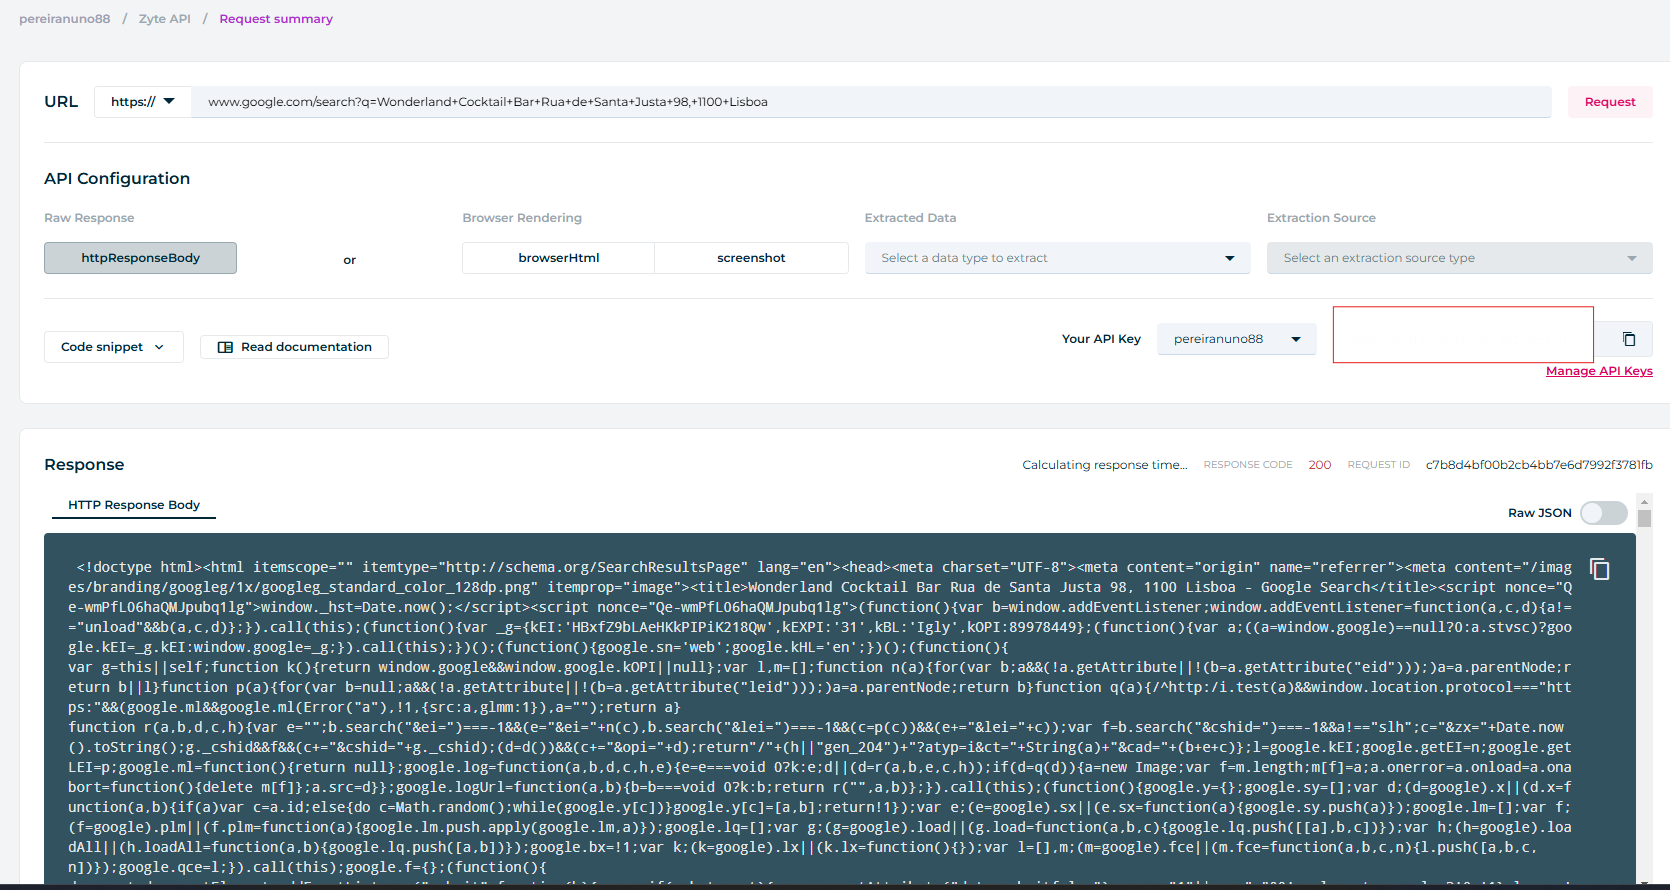

No código abaixo é apresentado o numero de cafés apurados na Baixa Pombalina

In [20]:
# Filtrar o DataFrame com base na coluna "is_valid" para identificar quantos Cafés existem na Baixa Pombalina
validated_df = finaldata_df[finaldata_df["is_valid"] == True]

# Contar o número de registos
records_no = len(validated_df)

# Apresentar o resultado
print("=" * 50)
print(f"📊 Resultado da Validação ")
print("-" * 50)
print(f"✅ Número de cafés em baixa Pombalina  validados: {records_no}")
print("=" * 50)

📊 Resultado da Validação 
--------------------------------------------------
✅ Número de cafés em baixa Pombalina  validados: 36



De seguida o resultado anterior é representado geograficamente  através da biblioteca Folium e assim conseguimos  verificar posição dos resultados  face  aos limites geográficos definidos na análise. Os pontos de interesse são marcados a azul, enquanto os limites geográficos são destacados com uma linha vermelha. A representação geográfica é apresentada num ficheiro html. Como é possivel ver abaixo, todos os pontos encontram-se dentro da zona de limite geográfica definida.

In [21]:
# Centrar o mapa num ponto através do calculo da média das latitudes/longitudes dos pontos de interesses encontrados.
map = folium.Map(location=[validated_df["position_lat"].mean(), validated_df["position_lon"].mean()], zoom_start=14)

# Marcar no mapa os pontos de interesse
for _, row in validated_df.iterrows():
    folium.Marker(
        location=[row["position_lat"], row["position_lon"]],
        popup=row["name"],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map)

# Marcar no mapa  limite geográfico da análise.
df_polygon_vertex = pd.read_csv(COORDINATES_FILE)
folium.PolyLine(
    locations=df_polygon_vertex[["lat", "lon"]].values.tolist(),
    color='red',  # Cor da linha
    weight=10,  
    opacity=0.8  # Transparência
).add_to(map)

map.save("display_poi_vertexpolygon_map.html")

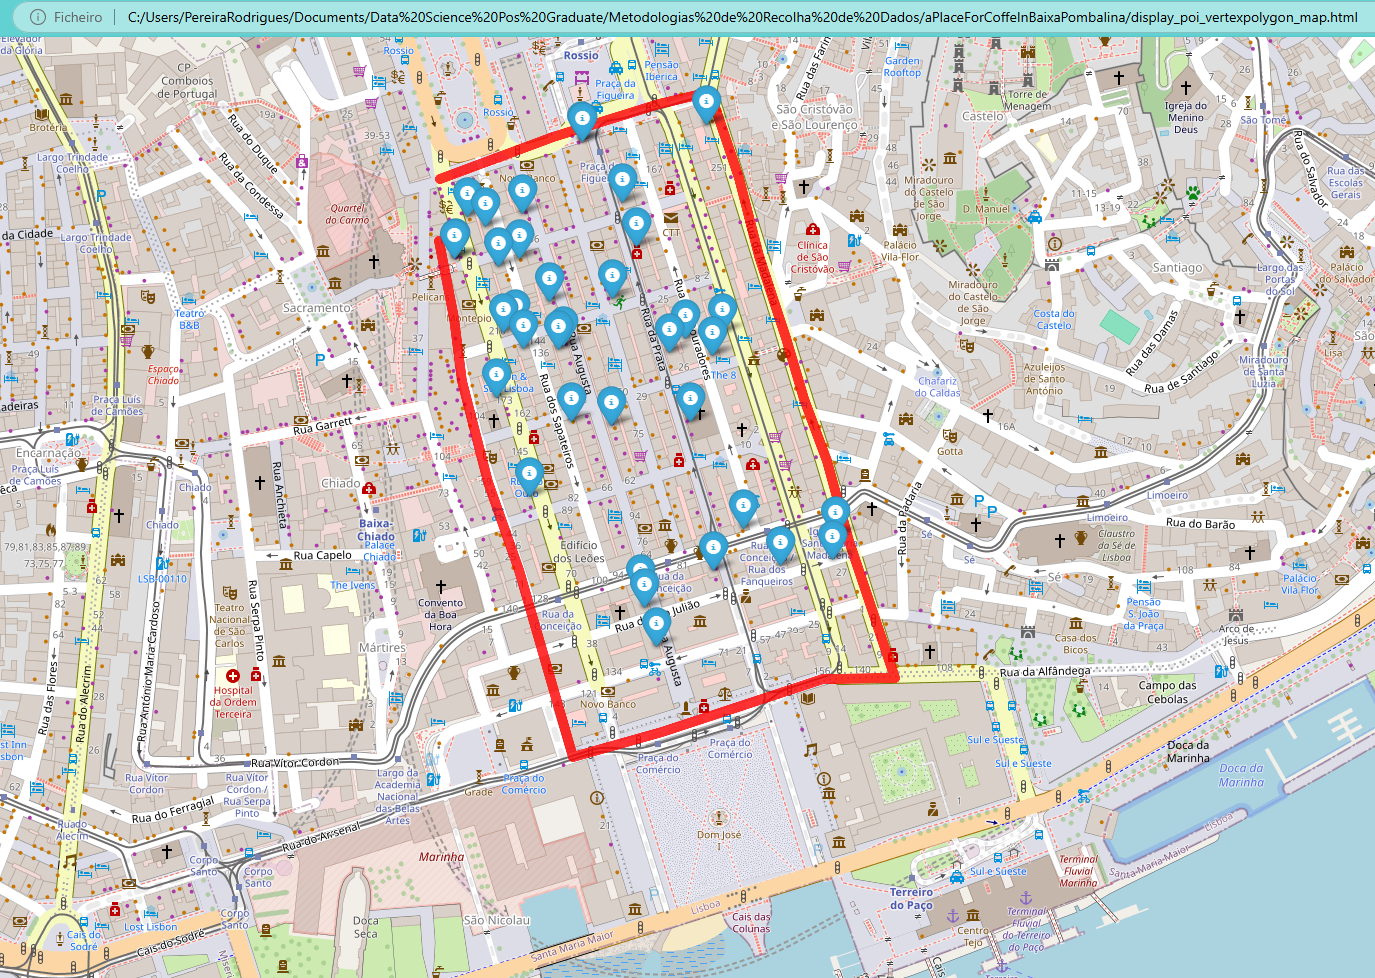

## Observações : 

### Falsos Positivos
<p>Os <span class="highlight">falsos positivos</span> referem-se a resultados indevidamente classificados como "cafés" ou "cafés" que não se encontram no limite geográfico definido. Estes podem surgir devido a várias causas, como <span class="highlight">classificação incorreta</span> na API, quer na categoria atribuída, quer na informação geográfica associada.</p>    
<h4>Processo de Validação</h4>
<p>Para mitigar estes cenários, foram implementadas várias <span class="highlight">etapas de filtragem</span>:</p>
<ul>
<li><strong>Verificação de conteúdos</strong> contra <span class="highlight">palavras-chave</span> de inclusão e exclusão;</li>
<li><strong>Validação com uma fonte adicional</strong>, recorrendo ao <span class="highlight">motor de pesquisa da Google</span> com as informações fornecidas;</li>
<li><strong>Remoção de duplicados</strong>;</li>
<li>Apresentação dos pontos validados dentro do limite geográfico definido como <span class="highlight">"Baixa Pombalina"</span>.</li>
</ul>

<p>Apesar dos processos de validação aplicados, existe a possibilidade de ainda persistirem <span class="highlight">falsos positivos</span> nos dados apresentados. Seria, por isso, interessante realizar uma <span class="highlight">validação cruzada</span> com mais uma fonte independente.</p>




### Falsos Negativos
<p>Os <span class="highlight">falsos negativos</span> referem-se a resultados indevidamente excluídos, ou seja, locais que deveriam ter sido identificados como "cafés" na área geográfica definida, mas que acabaram por não ser contabilizados no resultado final deste trabalho.</p> <p>O conceito de **"Baixa Pombalina"** foi delimitado através de um polígono, proporcionando uma abordagem altamente personalizada. Contudo, uma definição incorreta desse polígono pode excluir resultados que deveriam ser considerados, especialmente quando comparado a outros métodos, como a utilização de uma área circular definida por um centro e um raio.</p>
    
<h4>Outros Motivos para Falsos Negativos</h4>
<p>Durante o processo de tratamento da informação, algumas exclusões baseadas em <span class="highlight">palavras-chave de exclusão</span> podem ter eliminado mais registos do que o desejado, levando à omissão de pontos relevantes.</p>
    
<p>Adicionalmente, a API apresenta algumas <span class="highlight">limitações</span>:</p>
<p>Para esta análise, o número total de resultados foi inferior ao limite máximo por página, o que minimizou o impacto imediato dessas limitações.</p>
O parâmetro <span class="highlight">offset</span>, que permite paginar os resultados da API, não está a funcionar corretamente.
<p>Se a delimitação geográfica utilizada fosse maior do que a definida, esta limitação poderia levar à exclusão indevida de resultados relevantes.</p>
<p>Por este motivo, é importante considerar estas limitações e, sempre que possível, validar os dados com fontes complementares.</p>

